# Ring Background Estimation for GRB 190829A

## Introduction:

- In IACT data analysis, it is important to account for the large residual hadronic emission from the atmosphere or from different sources in the sky. 
- To make sure that the photons collected are from an exact position, an excess map, assumed to be a map of only gamma-ray events need to be produced, and requires a good estimate of the background. Here Background refer to other particle's or photons that comes from the target of interest (- protons, hadrons, CMBs, ...). 
- To optain a reliable background it is a bit complicated due to the lack of a solid template bkg model. 
- D. Berge et al 2007, introduced different background normalisation template that are necessary in classical cherenkov astronomy to perform a local renormalization of the existing templates, here we are interested in a ring kernel. 
- This assumes that most of the events are background and requires to have an exclusion mask to remove regions with bright signal from the estimation. 
- To read more about this method, see [here](https://arxiv.org/pdf/astro-ph/0610959.pdf).

## Objective

- We aim at Creating an excess Map (gamma-ray events) map of GRB 190829A as well as a significance map to determine how solid the signal is. We will also provide different maps for a detail exploration.

## Methods

- We will start by Computing the sky maps keeping each observation separately using the Analysis class (High level interfance) 
- We will estimate the background using the RingBackgroundMaker class provided in gammapy 
- We will compute the correlated excess and significance maps using the ExcessMapEstimator, taking into account the colleration radius (r = 0.05 deg) and in addition we will estimate background, Test statistics (TS) and upper limit maps at 3 sigma and a/symmetric errors at 1 sigma.

- The normalised background thus obtained can be used for general modelling and fitting.

## Implimentation

- We will start by importing different classes of gammapy!


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy 
from astropy import units as u
from astropy.convolution import Tophat2DKernel
from astropy.coordinates import SkyCoord
import os
import scipy.optimize
from scipy.stats import norm
import regions
from regions import CircleSkyRegion

In [2]:
# specific gammapy packages
import gammapy
from gammapy.makers import (
    MapDatasetMaker, 
    RingBackgroundMaker,
    SafeMaskMaker,
)
from gammapy.datasets import (
    MapDataset, 
    MapDatasetOnOff,
)
from gammapy.data import DataStore
from gammapy.maps import (
    MapAxis, 
    WcsGeom, 
    Map,
)
from gammapy.estimators import ExcessMapEstimator

print ('Astropy version:', astropy.__version__)
print ('Regions version:', gammapy.__version__)
print ('Gammapy version:', gammapy.__version__)

Astropy version: 4.0.3
Regions version: 0.17
Gammapy version: 0.17


In [10]:
import warnings
warnings.filterwarnings('ignore')

## Matplotlib parameter update

- latex
- label size
- fontsize

In [3]:
W = 10
fontsize = 16

params = {
    'figure.figsize': (W, W/(4/3)),
    'axes.labelsize': 'x-large',
    'axes.titlesize':'x-large',
    'xtick.labelsize':'x-large',
    'ytick.labelsize':'x-large',
    'font.size' : fontsize,
    'text.usetex': True,
    'text.latex.preamble': (
        r'\usepackage{lmodern}'),
    'font.family': 'lmodern',
    'legend.fontsize': fontsize,
}

plt.rcParams.update(params)

### Save figure and format output

In [4]:
run_list = "night1"
bkgmodel_version = "v07c"

work_dir = "/Users/jean/Documents/PhD/gammapy/GRBs/190829A/v17/new_analysis/grb_analysis/"
def save(fig, figname, left = 0.15, bottom = 0.15, right = 0.95, top = 0.95):
    fig.subplots_adjust(left = left, bottom = bottom, top = top, right = right)
    format_fig = [ 'png' , 'pdf' ] # 'eps'
    for form in format_fig:
        fig.savefig(work_dir + "plots/plots_2D/{}/jupyter_notebook/grb190829A_{}_{}.{}"
                    .format(run_list,run_list, figname, form))

## Run list

- Next we define the run list we wish to use (We will load data for these specific run list) see below, ...
- The source was observed in 3 consective nights. In the main paper, the first night was divided into 3 clusters to check how the source was varying during the first night. We will make clusters in the spectral and lightcurves analysis. The run list we used below are the standard impact full enclose as export in fits (see, Dan parsons paper about the methods, ... add a link here).

In [5]:
runs_night1 = [152900, 152901, 152902, 152903, 152904, 152905, 152906, 152907]
runs_night2 = [152960, 152961, 152962, 152963, 152965, 152966, 152967, 152968, 152969, 152970]
runs_night3 = [153040, 153041, 153042, 153043, 153044, 153047, 153048, 153049, 153050] # 153045 (too short, less than 15 mins)

if run_list == 'night1':
    runs = runs_night1
    
elif run_list == 'night2':
    runs = runs_night2
    
elif run_list == 'night3':
    runs = runs_night3
    
elif run_list == 'all_nights':
    runs = runs_night1 + runs_night2 +runs_night3

## Define source position and load the data.
- The source we are going to analyse if GRB 190829A observed from 29/08/2019 to 31/09/2019 by H.E.S.S,  initially detected by Fermi-GBM. The final position of the source was RA = +44.544 and DEC = -8.958 (units are in degrees). 

In [12]:
ra = 44.544
dec = -8.958

star_ra = 44.106
star_dec = -8.989
source_pos = SkyCoord(ra, dec, frame = 'icrs', unit = 'deg')
star_pos = SkyCoord(star_ra, star_dec, frame = 'icrs', unit = 'deg')
ds = DataStore.from_dir("$GAMMAPY_DATA/std_ImPACT_fullEnclosure")
observations = ds.get_observations (runs)

#print(observations)

### Datasets Geometry

- We start by defining the Geometry to use for the data reduction. We start with a logarthmic energy axis with in 0.13 - 56 TeV. 
- H.E.S.S have a FoV of 5 deg for CT 1-4 while CT5 has FoV of 3.5 deg. In our case, CT5 participated only in the first night might be interesting to analyse them alone. i will consider a moreless FoV of 4 deg.

- We first use 3d acceptance from the data and convert it to a 2D image.


In [9]:
energy_axis = MapAxis.from_edges ( 
    np.logspace(-0.875, 1.75, 43), unit = 'TeV', name = 'energy', interp = 'log'
                                 
                                 )

geom = WcsGeom.create( 
    skydir=source_pos,
    binsz = 0.02,
    width = (4, 4),
    frame = 'icrs',
    axes = [energy_axis],
)

geom_image = geom.to_image().to_cube([energy_axis.squash()])

#print(energy_axis)

## Make data reduction


In [11]:
%%time

maker = MapDatasetMaker( selection = ['counts', 'exposure', 'background'])

maker_safe_mask = SafeMaskMaker(methods = ['offset-max'], offset_max = 2.5 *u.deg )

reference = MapDataset.create(geom)

datasets = []

for obs in observations:
    dataset = maker.run(reference, obs)
    dataset = maker_safe_mask.run(dataset, obs)
    datasets.append(dataset)

CPU times: user 8.5 s, sys: 2.66 s, total: 11.2 s
Wall time: 11.6 s


# Extracting the ring background

- The ring background is extracted from real off events,the w-stat statistics in this case, will be used. - For this, we will use the MapDatasetOnOFF and the RingBackgroundMaker classes.

## Create exclusion mask

- First, we need to create an exclusion mask on the known sources.
- In this case, we need to mask only GRB190829A and a star near them, but this depends on the sources present in our field of view.


In [30]:
# get the geom that we use
geom = datasets[0].counts.geom
energy_axis = datasets[0].counts.geom.get_axis_by_name("energy")
geom_image = geom.to_image().to_cube([energy_axis.squash()])

# Make the exclusion mask
region_grb = CircleSkyRegion(center= source_pos, radius=0.3 * u.deg)
region_star = CircleSkyRegion(center= star_pos, radius=0.1 * u.deg)
exclusion_mask = Map.from_geom(geom_image)
exclusion_mask.data = geom_image.region_mask([region_grb, region_star], inside=False)


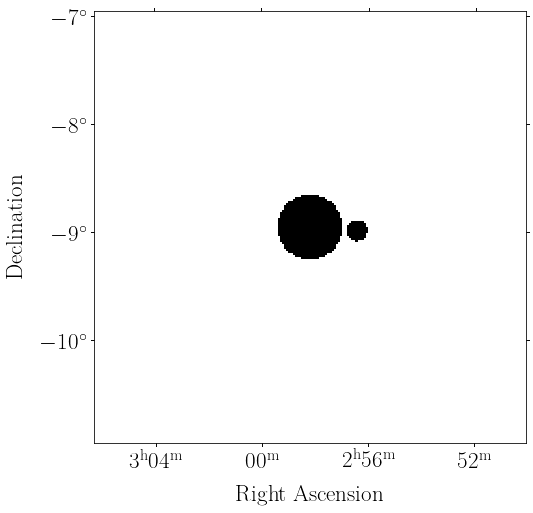

In [31]:
fig = plt.figure();

exclusion_mask.sum_over_axes().plot();
save(fig, '2D-exclusion-regions_low_level');

- The above figure, shows an exclusion region of size 0.3 deg roughly and a star located away at 0.4 deg from the GRB with size 0.2 deg. 

### Creating the ring 

- We use a ring with an inner radius of 0.5 deg and width of 0.3 deg just like in the gammapy tutorial (see tutorial [here](https://docs.gammapy.org/0.17/notebooks/ring_background.html?highlight=ringbackground)).


In [32]:
ring_maker = RingBackgroundMaker (
    r_in = 0.5*u.deg, width = 0.3 *u.deg, exclusion_mask = exclusion_mask
)

## Creating now the ON and OFF dataset

In [33]:
%%time
# for this we need to stack all observations together.
stacked_on_off = MapDatasetOnOff.create(geom = geom_image, name = 'grb-stacked')
for dataset in datasets:
    dataset_image = dataset.to_image()
    dataset_on_off = ring_maker.run(dataset_image)
    stacked_on_off.stack(dataset_on_off)

CPU times: user 796 ms, sys: 326 ms, total: 1.12 s
Wall time: 1.13 s


In [34]:
print ( stacked_on_off)

MapDatasetOnOff
---------------

  Name                            : grb-stacked 

  Total counts                    : 22451 
  Total predicted counts          : nan
  Total background counts         : nan

  Exposure min                    : 7.04e+07 m2 s
  Exposure max                    : 1.17e+09 m2 s

  Number of total bins            : 40000 
  Number of fit bins              : 40000 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

    Total counts_off                : 57893296 
    Acceptance                      : 40000 
    Acceptance off                  : 106732431 



## Let's see what we have just done so far:

### a) ON exposure Map

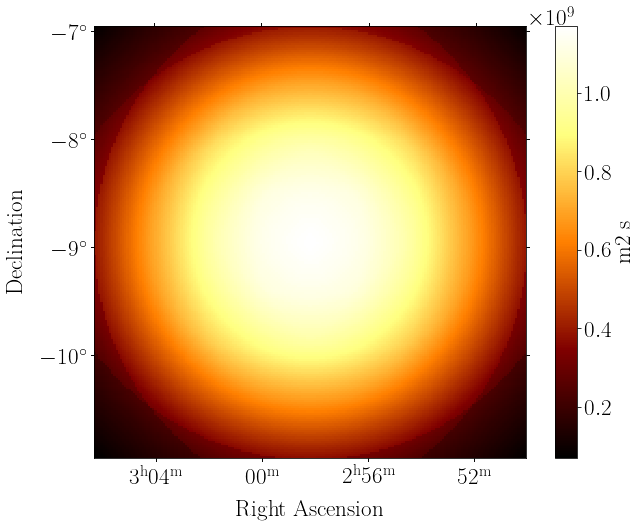

In [35]:
fig = plt.figure()
f_exp_on = stacked_on_off.exposure.sum_over_axes().plot(add_cbar = True)[0]
save(fig, '2D-On-exposure-map_low_level')

## b) Off exposure Map

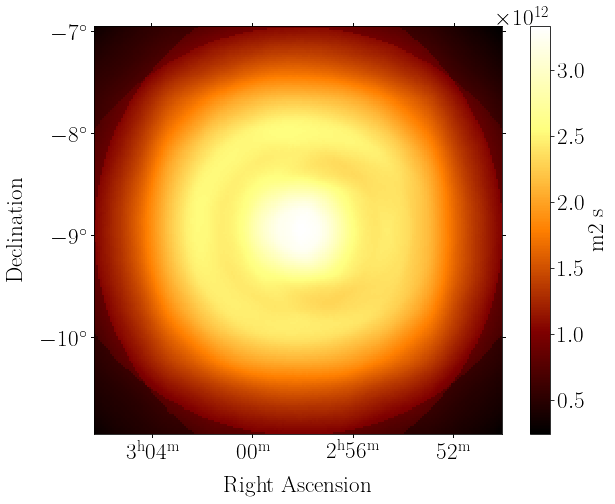

In [36]:
exp_off = stacked_on_off.exposure.sum_over_axes()*stacked_on_off.acceptance_off.sum_over_axes()
f_exp_off = exp_off.sum_over_axes().plot(add_cbar = True)[0]
save(fig, '2D-off-exposure-map_low_level')

## c) On-Counts map

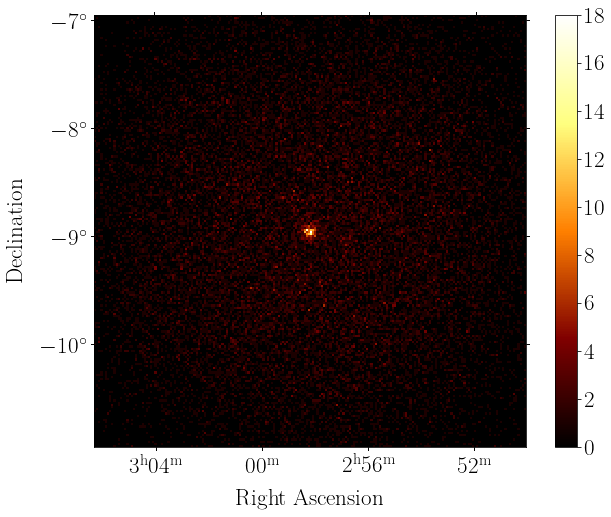

In [37]:
fig,ax,_ = stacked_on_off.counts.sum_over_axes().plot(add_cbar = True)
save(fig, '2D-On-counts_maps_low_level')

## d) Off-counts map

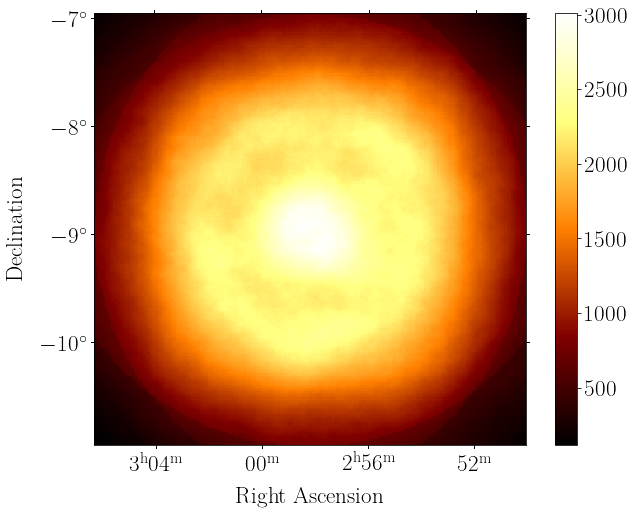

In [38]:
fig, ax,_ = stacked_on_off.counts_off.sum_over_axes().plot(add_cbar = True)
save(fig, '2D-off-counts-maps_low_level')

## e) Alpha Map

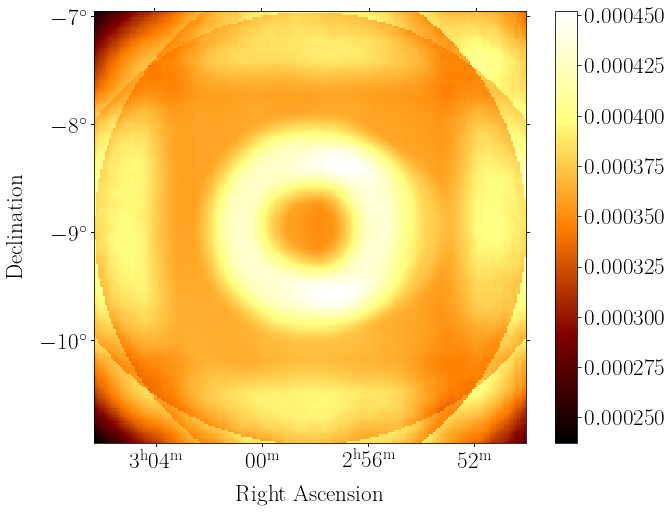

In [39]:
fig, ax,_ = stacked_on_off.alpha.sum_over_axes().plot(add_cbar = True)
save(fig, '2D-Alpha-maps_low_level')

## Residual count map

<Figure size 720x540 with 0 Axes>

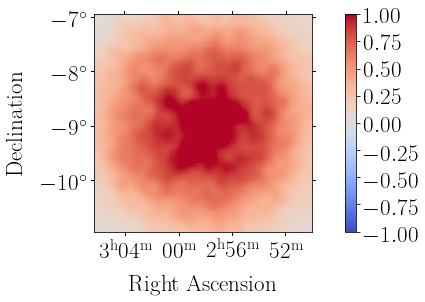

In [43]:
fig = plt.figure();
fig,ax = stacked_on_off.plot_residuals(vmin = -1, vmax=1);

# Estimating Li & Ma maps

### Compute correlated significance and correlated excess maps

- By convolving our maps with an apprpriate smoothing kernel, we can compute the significance according to the Li & Ma expression for ON and OFF Poisson measurements, see [here](https://ui.adsabs.harvard.edu/abs/1983ApJ...272..317L/abstract). Since astropy convolution kernels only accept integers, we first convert our required size in degrees to int depending on our pixel size.

- The ExcessMapEstimater will calculate many maps, including: Excess Map, Flux map, Background map, significance map and many more, ...

In [44]:
%%time
# Using a convolution radius of 0.04 degrees, in the tutorial. Changed to 0.05 deg!
estimator = ExcessMapEstimator(0.05 * u.deg, )
lima_maps = estimator.run(stacked_on_off, steps="all")

CPU times: user 5min 13s, sys: 24.4 s, total: 5min 37s
Wall time: 5min 39s


# Results of the analysis
## 1. Cliped Excess map [clipped at zero]

- The first thing to look at is the excess map, here we clipped the map by setting at a minimum value of zero.

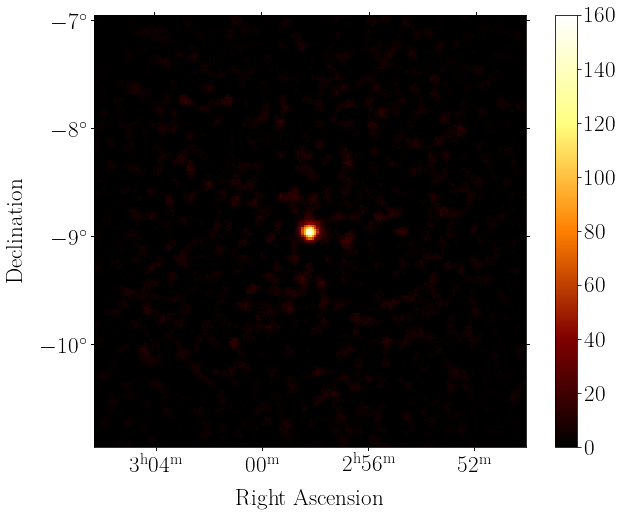

In [45]:
map_excess_clipped = lima_maps['excess'].copy()
map_excess_clipped.data = map_excess_clipped.data.clip(min = 0)
fig, ax,_ = map_excess_clipped.sum_over_axes().plot(add_cbar = True)
save(fig, '2D-excess-map_low_level')

## 2. Excess map with source excluded.
- It is also with no harm to look at the Excess map with excluded regions:

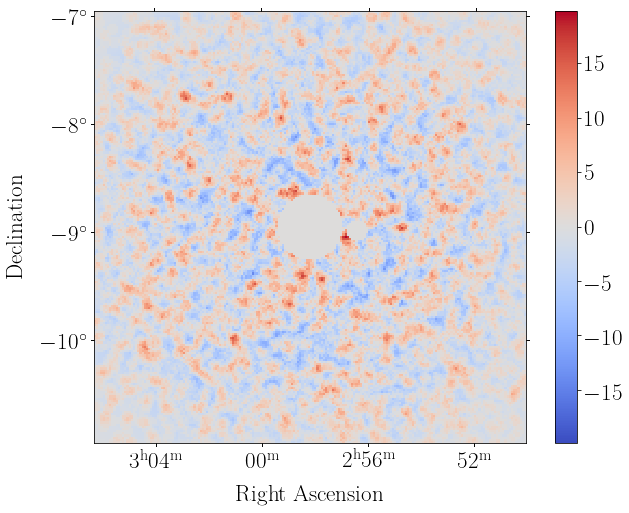

In [46]:
map_excess_excl = lima_maps['excess'].copy()
map_excess_excl.data[:] *= exclusion_mask.data[0]
maxentry = np.abs(map_excess_excl.data).max()
fig,ax,_ = map_excess_excl.sum_over_axes().plot(
    add_cbar = True, cmap='coolwarm', vmin = -maxentry, vmax=maxentry
                                               );
save(fig, '2D-excess_map_withexclusion_low_level');

## 3. Background Map

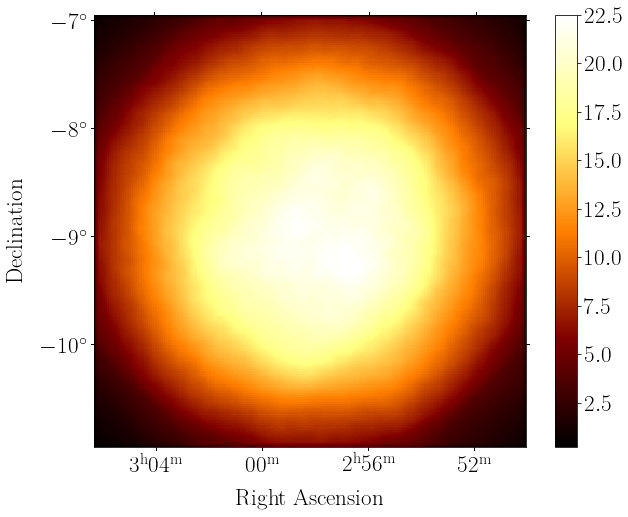

In [47]:
fig,ax,_ = lima_maps['background'].sum_over_axes().plot(add_cbar = True);
save(fig, '2D-background-map_low_level');

## 4. Symmetric error Map

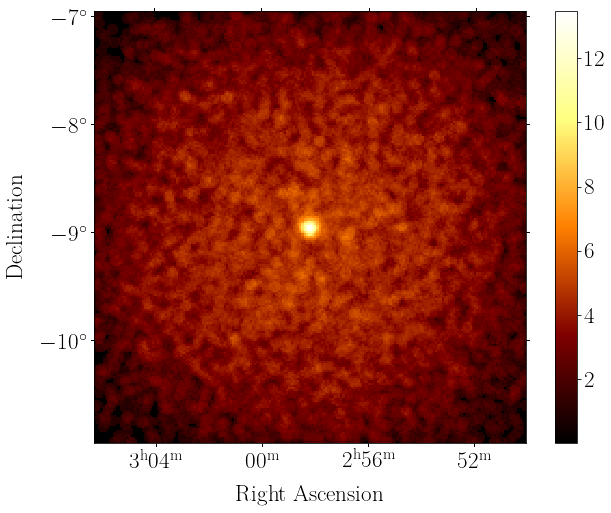

In [49]:
fig,ax,_ = lima_maps['err'].sum_over_axes().plot(add_cbar = True);
save(fig, '2D-symetric_error-map_low_level');

## 5. Negative Asymmetric error Map.

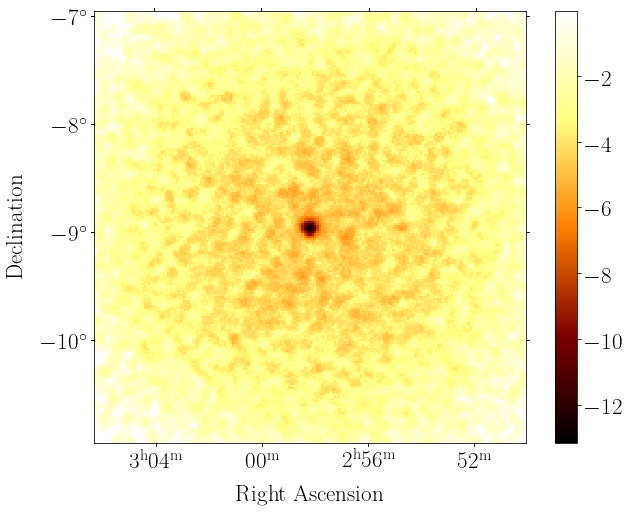

In [50]:
fig,ax,_ = lima_maps['errn'].sum_over_axes().plot(add_cbar = True);
save(fig, '2D-negative_asymmetric_error-map_low_level');

## 6. Positive Asymmetric error Map.

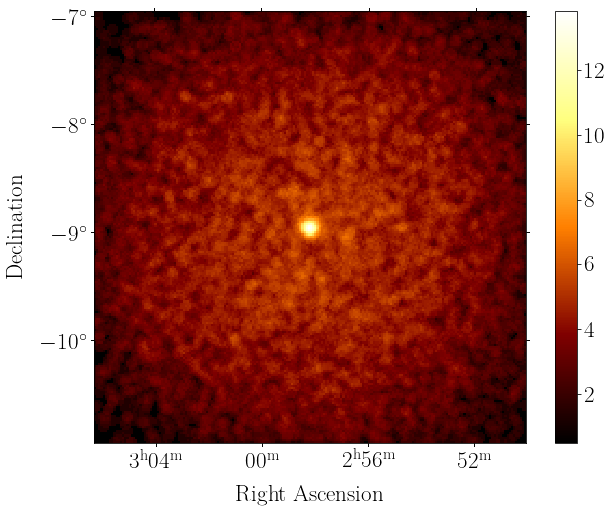

In [51]:
fig,ax,_ = lima_maps['errp'].sum_over_axes().plot(add_cbar = True);
save(fig, '2D-positive_asymmetric_error-map_low_level');

## 7. Upper limit Map.

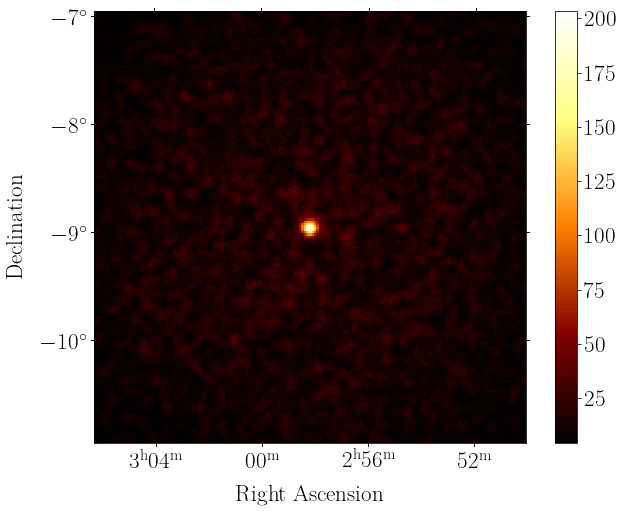

In [52]:
fig,ax,_ = lima_maps['ul'].sum_over_axes().plot(add_cbar = True);
save(fig, '2D-upperlimit-map_low_level');

## 8. Test Statistic Map

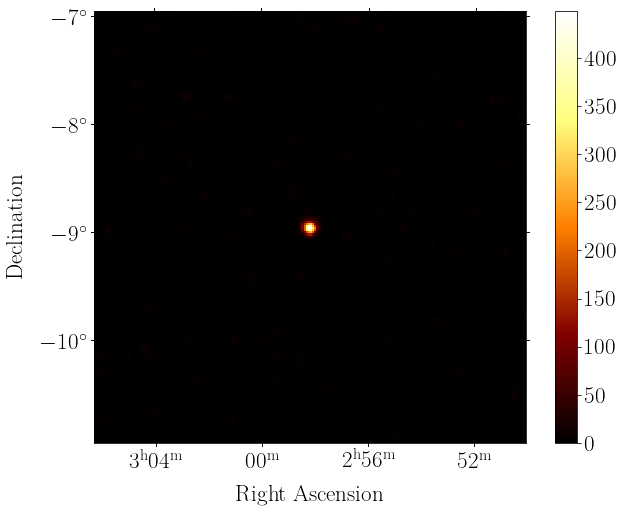

In [53]:
fig,ax,_ = lima_maps['ts'].sum_over_axes().plot(add_cbar = True);
save(fig, '2D-TS-map_low_level');

## 9. Significance map

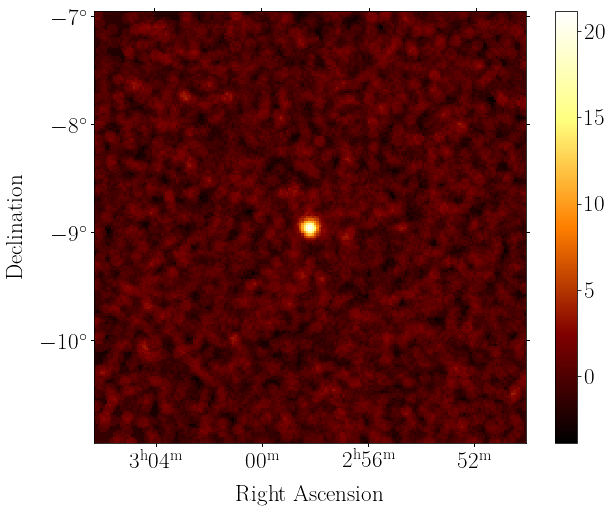

In [54]:
map_sign_clipped = lima_maps['significance'].copy()
#map_sign_clipped.data = map_sign_clipped.data.clip(min=0) # do not clip
fig,ax,_ = map_sign_clipped.sum_over_axes().plot(add_cbar = True)
save(fig, '2D-significance-map_low_level');

## 10. Significance map with source excluded

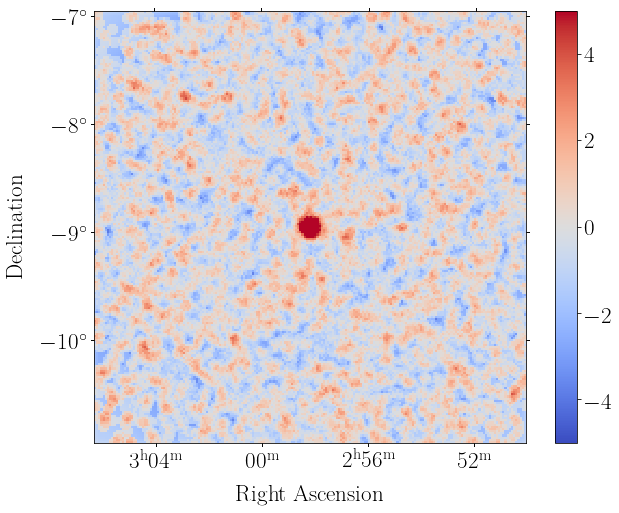

In [55]:
map_sign_excl = lima_maps['significance'].copy()

# map_sign_excl.data *= mask.data[0]

fig,ax,cb = map_sign_excl.sum_over_axes().plot(
    add_cbar = True, cmap = 'coolwarm', vmin=-5, vmax=5, 
                                              )
save(fig, '2D-significance-map_with_exclusion_low_level')

## 11. Significance distribution 
### (include only pixels within 2.25 deg radius)

- The signficance distribution outside the exclusion region was shown, to check whether the background estimation is not contaminated by gamma-ray events. 
- This can be the case when exclusion regions are not large enough. Typically, we expect the off distribution to be a standard normal distribution (see plot below and the last one).

findfont: Font family ['lmodern'] not found. Falling back to DejaVu Sans.


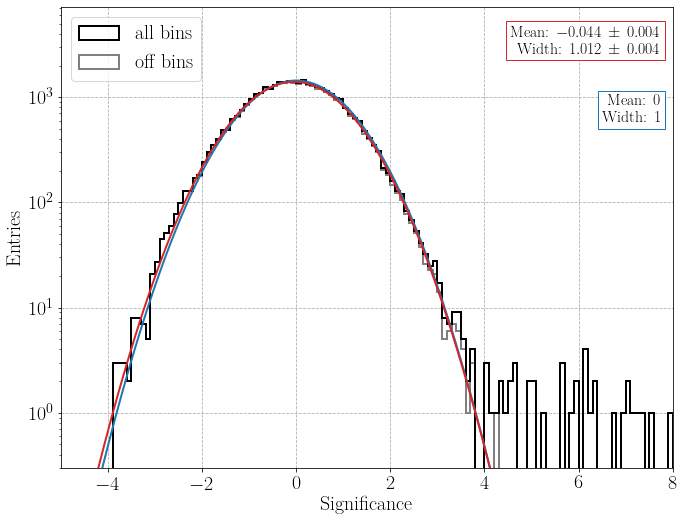

In [58]:
sdbins = np.linspace (-5, 8,131)
def get_binc(bins):
    bin_center = (bins[:-1] + bins[1:]) / 2
    return bin_center
reg_inner = CircleSkyRegion(source_pos, 2.25 * u.deg)
inner = geom.region_mask([reg_inner], inside=True)[0]

sign_inner = lima_maps['significance'].sum_over_axes().data[inner]

sign_excl = map_sign_excl.sum_over_axes().data.copy()
sign_excl[~exclusion_mask.data[0].astype(bool)] = -999.
sign_excl_inner = sign_excl[inner]
sign_inner[np.isnan(sign_excl_inner)] = -999.
sign_excl_inner[np.isnan(sign_excl_inner)] = -999.

fig = plt.figure(figsize=(10, 8))
ax = fig.add_axes([0.12, 0.12, 0.85, 0.8])
ax.grid(ls='--')
ax.set_yscale('log')
ax.set_xlabel('Significance', fontsize =20)
ax.set_ylabel('Entries', fontsize =20)
h = ax.hist(sign_inner, bins=sdbins, histtype='step', color='k', lw=2, zorder=5, label = 'all bins')[0]
h = ax.hist(sign_excl_inner, bins=sdbins, histtype='step', color='gray', lw=2, zorder=3, label = 'off bins')[0]

gaus = lambda x,amp,mean,sigma:amp*np.exp(-(x-mean)**2/2/sigma**2)
xv = np.linspace(sdbins[0], sdbins[-1], 1000)
res = scipy.optimize.curve_fit(gaus, get_binc(sdbins), h, p0=[h.max(), 0., 1.])
pars = res[0]
errs = np.sqrt(np.diag(res[1]))
ax.plot(xv, gaus(xv, pars[0], pars[1], pars[2]), color='tab:red', lw=2, zorder=7)

ax.text(0.98, 0.96, 'Mean: ${:.3f}\,\pm\,{:.3f}$\nWidth: ${:.3f}\,\pm\,{:.3f}$'.format(pars[1],errs[1], pars[2], errs[2]),
        ha='right', va='top', bbox=dict(edgecolor='tab:red', facecolor='white'), transform=ax.transAxes, fontsize=16)

ax.plot(xv, gaus(xv, h.max(), 0, 1), color='tab:blue', lw=2, zorder=6)

ax.text(0.98, 0.81, 'Mean: $0$\nWidth: $1$', ha='right', va='top',fontsize=16,
        bbox=dict(edgecolor='tab:blue', facecolor='white'), transform=ax.transAxes)

ax.set_xlim(sdbins[0], sdbins[-1])
ax.set_ylim(bottom=0.3)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.legend(loc = 'upper left',fontsize=20)
# format_log_axis(ax.yaxis)
save(fig, '1D_significance_distribution_low_level')

## 12. Theta^2 Distribution plot.

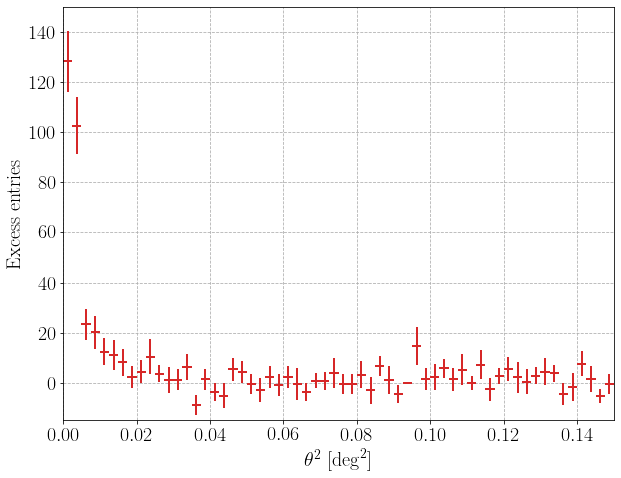

In [59]:
# Theta^2 plot
tsbins = np.linspace(0, 0.3, 121)
excess_noconv = stacked_on_off.excess
excess_noconv_err = np.sqrt(stacked_on_off.counts.sum_over_axes().data +\
                            stacked_on_off.alpha.data**2 * stacked_on_off.counts_off.sum_over_axes().data)
thsq = stacked_on_off.counts.geom.get_coord().skycoord.separation(source_pos).value**2
thsq_excess = np.histogram(thsq, bins=tsbins, weights=excess_noconv)[0]
thsq_excess_err = np.sqrt(np.histogram(thsq, bins=tsbins, weights=excess_noconv_err**2)[0])

tsbinc = get_binc(tsbins)
xerr = [tsbinc - tsbins[:-1], tsbins[1:] - tsbinc]

# create figure
fig = plt.figure(figsize=(9, 7))
ax = fig.add_axes([0.12, 0.15, 0.85, 0.82])
ax.grid(ls='--')
ax.set_xlabel(r'$\theta^2$ [$\mathrm{deg}^2$]', fontsize = 20)
ax.set_ylabel('Excess entries', fontsize = 20)

# plot distributions
pexc = ax.errorbar(tsbinc, thsq_excess, xerr=xerr, yerr=thsq_excess_err, linestyle='None',
                   ecolor='tab:red', capsize=0, elinewidth=2)

# set axis limits
ax.set_xlim(tsbins[0], 0.15)
ax.set_ylim(-15, 150)
ax.tick_params(axis='both', which='major', labelsize=20)
save(fig, '1D-thetasquare_distribution_low_level');

## 13. Total significance 
### Distribution Histogram in the whole FoV.

Fit results: mu = -0.06, std = 1.01


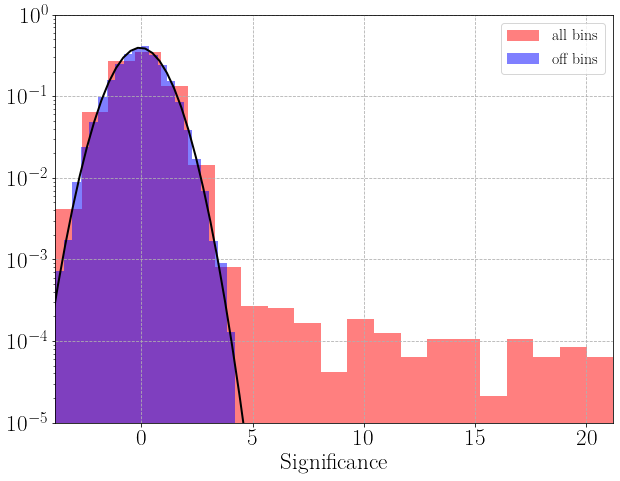

In [61]:
# create a 2D mask for the images
significance_map_off = lima_maps['significance'] * exclusion_mask
significance_all = lima_maps['significance'].data[np.isfinite(lima_maps['significance'].data)]
significance_off = significance_map_off.data[
    np.isfinite(significance_map_off.data)
]

plt.hist(
    significance_all,
    density=True,
    alpha=0.5,
    color="red",
    label="all bins",
    bins=21,
)

plt.hist(
    significance_off,
    density=True,
    alpha=0.5,
    color="blue",
    label="off bins",
    bins=21,
)

# Now, fit the off distribution with a Gaussian
mu, std = norm.fit(significance_off)
x = np.linspace(-8, 8, 50)
p = norm.pdf(x, mu, std)
plt.plot(x, p, lw=2, color="black")
plt.legend()
plt.xlabel("Significance")
plt.yscale("log")
plt.ylim(1e-5, 1)
xmin, xmax = np.min(significance_all), np.max(significance_all)
plt.xlim(xmin, xmax)
plt.grid(ls='--')
save(fig, 'Total_significance_distribution_low_level')
print(f"Fit results: mu = {mu:.2f}, std = {std:.2f}")